# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [143]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

__Data Exploration & Wrangling__

Porfolio dataset

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


I will perform two operations for cleaning the portfolio.json data:
1) Change the column id to offer_id \
2) Split the channels list of string into multiple columns so that we can have 1's and 0's and use these feature later in our analysis and model \
3) Split the  offer_type column to also get the dumies and use this as a feature. \ 
4) Add a prefix to the reward column 

In [6]:
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)

In [7]:
portfolio.rename(columns = {'reward':'offer_reward'}, inplace = True)

In [8]:
portfolio.head(1)

,offer_reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [9]:
dummy_channels_df = pd.get_dummies(portfolio['channels'].explode()).groupby(level=0).sum()

In [10]:
dummys_offer_type_df = pd.get_dummies(portfolio['offer_type'],prefix="offer_type")

In [11]:
portfolio = pd.concat([portfolio, dummy_channels_df, dummys_offer_type_df], axis=1)
portfolio.drop(columns='channels',inplace=True)
portfolio.drop(columns='offer_type',inplace=True)

In [12]:
portfolio

,offer_reward,difficulty,duration,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


Profile Dataset

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
profile.shape

(17000, 5)

In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


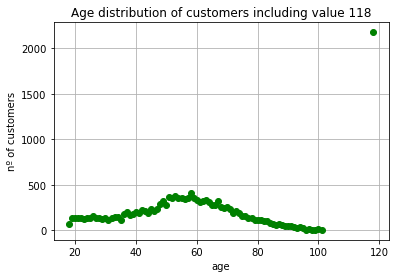

In [17]:
profile.groupby('age')['age'].count().plot(marker='o', linestyle='None',color='g')
plt.title("Age distribution of customers including value 118")
plt.grid(True)
plt.ylabel('nº of customers');

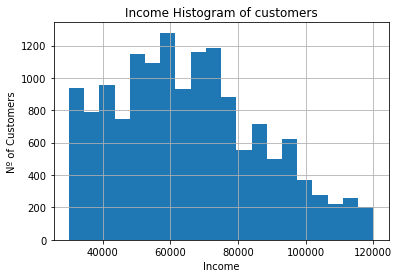

In [18]:

profile['income'].hist(bins=20)
plt.title('Income Histogram of customers')
plt.ylabel('Nº of Customers')
plt.xlabel('Income');

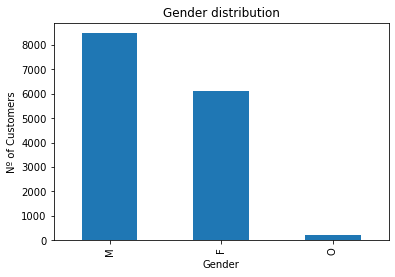

In [19]:
profile['gender'].value_counts().plot(kind='bar')
plt.title('Gender distribution')
plt.ylabel('Nº of Customers')
plt.xlabel('Gender');

Initially I will perform two operations for cleaning the profile.json data:
1) Change the column id to customer_id \
2) Change the became_member_on from int type to datetime type. \
3) Remove profiles that have the age 118 since it refers to an unknown age and otherwise it will take the value into consideration which we don't want. \
4) Convert the categorical gender column to encode getting the dummies function \
5) Conver the became member on to a customer loyalty in days by subtracting todays date to when they became members on.

In [20]:
profile.rename(columns = {'id':'customer_id'}, inplace = True)

In [21]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

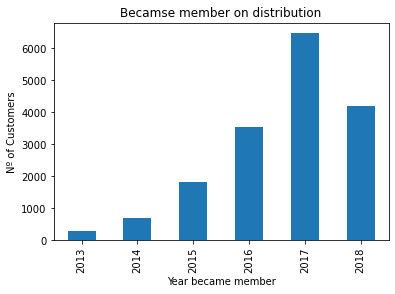

In [22]:
profile.groupby(profile.became_member_on.dt.year).count()['became_member_on'].plot(kind='bar')
plt.title('Becamse member on distribution')
plt.ylabel('Nº of Customers')
plt.xlabel('Year became member');

In [23]:
profile = profile[profile.age != 118]

In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   customer_id       14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


In [25]:
profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


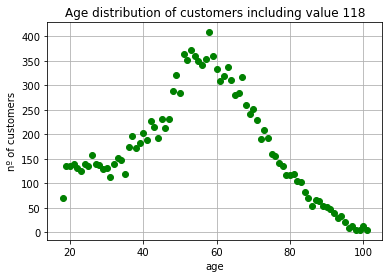

In [26]:
profile.groupby('age')['age'].count().plot(marker='o', linestyle='None',color='g')
plt.title("Age distribution of customers including value 118")
plt.grid(True)
plt.ylabel('nº of customers');


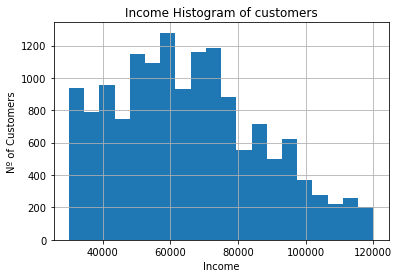

In [27]:

profile['income'].hist(bins=20)
plt.title('Income Histogram of customers')
plt.ylabel('Nº of Customers')
plt.xlabel('Income');

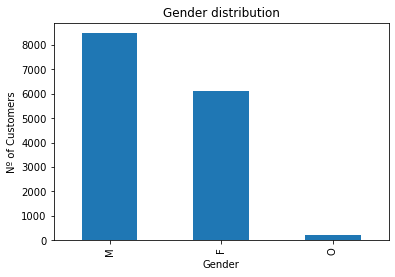

In [28]:
profile['gender'].value_counts().plot(kind='bar')
plt.title('Gender distribution')
plt.ylabel('Nº of Customers')
plt.xlabel('Gender');

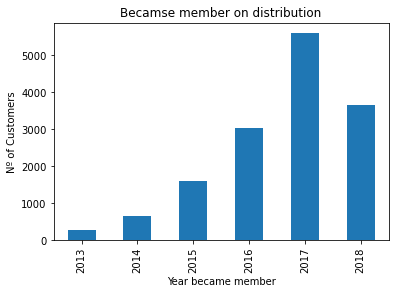

In [29]:
profile.groupby(profile.became_member_on.dt.year).count()['became_member_on'].plot(kind='bar')
plt.title('Becamse member on distribution')
plt.ylabel('Nº of Customers')
plt.xlabel('Year became member');

In [30]:
dummys_gender_df = pd.get_dummies(profile['gender'],prefix="gender")

In [31]:
date_now = datetime.datetime.now().date()

In [32]:
profile['customer_loyalty_days'] = (date_now - profile['became_member_on'].dt.date)

In [33]:
profile = pd.concat([profile, dummys_gender_df], axis=1)
profile.drop(columns='gender',inplace=True)
profile.drop(columns='became_member_on',inplace=True)

In [34]:
profile

,age,customer_id,income,customer_loyalty_days,gender_F,gender_M,gender_O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2132 days,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2199 days,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,1847 days,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,1923 days,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2013 days,0,1,0
...,...,...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,1808 days,1,0,0
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,1769 days,0,1,0
16997,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2302 days,0,1,0
16998,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,2627 days,1,0,0


Transcript Dataset

In [35]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [36]:
transcript.shape

(306534, 4)

In [37]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [38]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [39]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

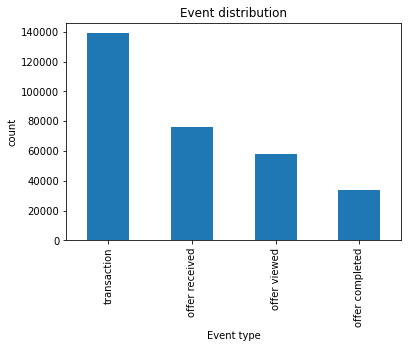

In [40]:
transcript['event'].value_counts().plot(kind='bar')
plt.title('Event distribution')
plt.ylabel('count')
plt.xlabel('Event type');

Initially I will perform two operations for cleaning the transcript.json data:
1) Change the column person to customer_id \
2) Get dummies for the event column but before doing so replace the string to have a underscore so instead of "offer completed" for example it is "offer_completed" \
3) Separate the value column into 3 different columns, offer_id which could be names as "offer_id" or "offer id", "amount" and "reward". \
4) Add a prefix to the reward column to make sure it is represented as the reward transcript column


In [41]:
transcript['event'] = transcript['event'].str.replace(' ', '_')


In [42]:
dummys_transcript_event_df = pd.get_dummies(transcript['event'],prefix="event")

In [43]:
offer_id_col = []
for row in transcript['value']:
    if list(row.keys())[0] in ['offer id','offer_id']:
        offer_id_col.append(list(row.values())[0])
    else:
        offer_id_col.append(None)

In [44]:
len(offer_id_col)

306534

In [45]:
amount_col = []
for row in transcript['value']:
    if list(row.keys())[0] == 'amount':
        amount_col.append(np.round(list(row.values())[0], decimals=2))
    else:
        amount_col.append(None)

In [46]:
len(amount_col)

306534

In [47]:
reward_col = []
for row in transcript['value']:
    if len(list(row.keys()))>1 and list(row.keys())[1] == 'reward':
        reward_col.append(np.round(list(row.values())[1], decimals=2))
    else:
        reward_col.append(None)

In [48]:
len(reward_col)

306534

In [49]:
transcript['offer_id'] = offer_id_col
transcript['amount'] = amount_col
transcript['reward'] = reward_col
transcript = pd.concat([transcript, dummys_transcript_event_df], axis=1)
transcript.drop(columns='value',inplace=True)
transcript.drop(columns='event',inplace=True)

In [50]:
transcript.rename(columns = {'person':'customer_id'}, inplace = True)

In [51]:
transcript.rename(columns = {'reward':'transcript_reward'}, inplace = True)

In [52]:
transcript

,customer_id,time,offer_id,amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,None,1.59,NaN,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,None,9.53,NaN,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,None,3.61,NaN,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,None,3.53,NaN,0,0,0,1


__Data Analysis__

In [53]:
transcript.groupby('offer_id').sum()

,time,amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
offer_id,,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,4993236,0.0,17100.0,3420.0,7668.0,2663.0,0.0
2298d6c36e964ae4a3e7e9706d1fb8c2,7238778,0.0,15468.0,5156.0,7646.0,7337.0,0.0
2906b810c7d4411798c6938adc9daaa5,5647476,0.0,8034.0,4017.0,7632.0,4118.0,0.0
3f207df678b143eea3cee63160fa8bed,4014168,0.0,0.0,0.0,7617.0,4144.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,6406716,0.0,33310.0,3331.0,7593.0,7298.0,0.0
5a8bc65990b245e5a138643cd4eb9837,4899552,0.0,0.0,0.0,7618.0,6687.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5847342,0.0,21770.0,4354.0,7677.0,4171.0,0.0
ae264e3637204a6fb9bb56bc8210ddfd,6349416,0.0,36880.0,3688.0,7658.0,6716.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,6700884,0.0,21480.0,4296.0,7571.0,7264.0,0.0


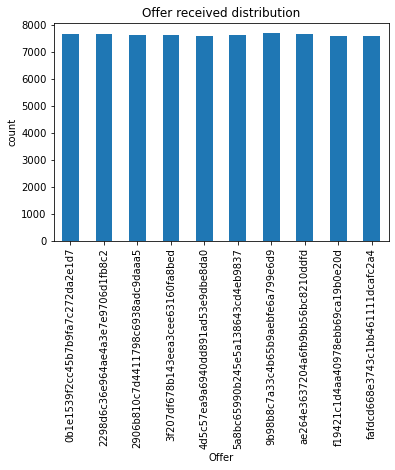

In [54]:
transcript.groupby('offer_id').sum()['event_offer_received'].plot.bar()
plt.title('Offer received distribution')
plt.ylabel('count')
plt.xlabel('Offer');

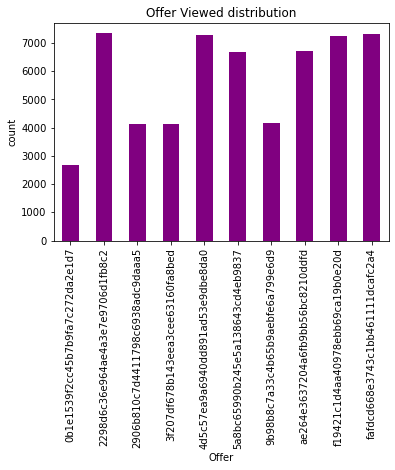

In [55]:
transcript.groupby('offer_id').sum()['event_offer_viewed'].plot(kind='bar', color='purple')
plt.title('Offer Viewed distribution')
plt.ylabel('count')
plt.xlabel('Offer');

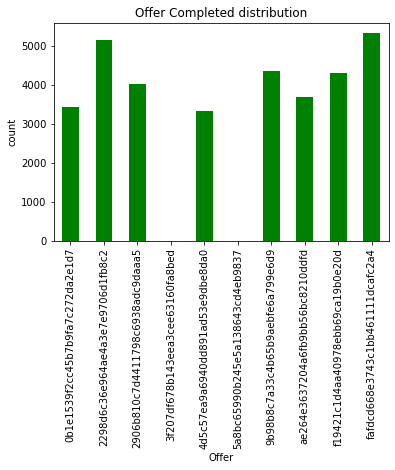

In [56]:
transcript.groupby('offer_id').sum()['event_offer_completed'].plot(kind='bar', color='green')
plt.title('Offer Completed distribution')
plt.ylabel('count')
plt.xlabel('Offer');

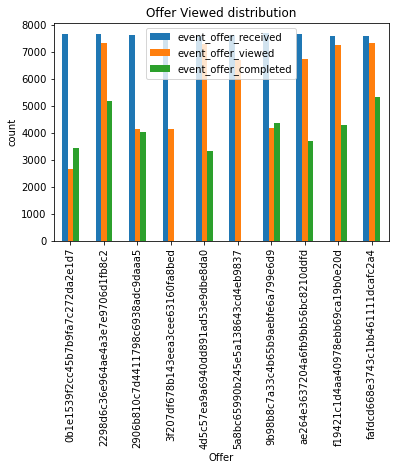

In [57]:
transcript.groupby('offer_id').sum().plot(kind='bar', y=['event_offer_received','event_offer_viewed','event_offer_completed'])
plt.title('Offer Viewed distribution')
plt.rcParams["figure.figsize"] = (30,20)
plt.ylabel('count')
plt.xlabel('Offer');

In [58]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            306534 non-null  object 
 1   time                   306534 non-null  int64  
 2   offer_id               167581 non-null  object 
 3   amount                 138953 non-null  float64
 4   transcript_reward      33579 non-null   float64
 5   event_offer_completed  306534 non-null  uint8  
 6   event_offer_received   306534 non-null  uint8  
 7   event_offer_viewed     306534 non-null  uint8  
 8   event_transaction      306534 non-null  uint8  
dtypes: float64(2), int64(1), object(2), uint8(4)
memory usage: 12.9+ MB


In [59]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   age                    14825 non-null  int64          
 1   customer_id            14825 non-null  object         
 2   income                 14825 non-null  float64        
 3   customer_loyalty_days  14825 non-null  timedelta64[ns]
 4   gender_F               14825 non-null  uint8          
 5   gender_M               14825 non-null  uint8          
 6   gender_O               14825 non-null  uint8          
dtypes: float64(1), int64(1), object(1), timedelta64[ns](1), uint8(3)
memory usage: 622.5+ KB


__Feature Engineering Amount spent before an offer is completed__

In [60]:
transcript.sort_values('amount', ascending=False)

,customer_id,time,offer_id,amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
284273,6cf884a6c5ae4b2daccb6d3108028fef,630,None,1062.28,NaN,0,0,0,1
301790,454b00bdd77c4f588eb9f6cafd81dc5d,690,None,1015.73,NaN,0,0,0,1
42253,5ecaea5c8bf44ae4a65838d9d066c909,102,None,1001.85,NaN,0,0,0,1
140346,dce784e26f294101999d000fad9089bb,372,None,989.34,NaN,0,0,0,1
302951,52959f19113e4241a8cb3bef486c6412,696,None,977.78,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,1,0,0,0
306506,b895c57e8cd047a8872ce02aa54759d6,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,1,0,0,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,0,1,0
306509,8431c16f8e1d440880db371a68f82dd0,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,1,0,0,0


Lets take an example to look at what the amount column is telling us. We can see for a specific customer, whenever a transaction is made, i.e. the column event_transaction == 1, then there is a value in amount which is when a customer makes a pruchase. Not always is this correlated to a user receiving, viewing or completing an offer, but for this project we will try and aggregate all this information into one main feature which is amount_spent, before an offer is completed, since we can imagine that this is correlated to whether the offer is completed or not.

In [61]:
transcript[transcript['customer_id'] == '6cf884a6c5ae4b2daccb6d3108028fef']

,customer_id,time,offer_id,amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
1976,6cf884a6c5ae4b2daccb6d3108028fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
55173,6cf884a6c5ae4b2daccb6d3108028fef,168,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,1,0,0
77568,6cf884a6c5ae4b2daccb6d3108028fef,192,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,0,1,0
89183,6cf884a6c5ae4b2daccb6d3108028fef,228,None,39.05,NaN,0,0,0,1
112788,6cf884a6c5ae4b2daccb6d3108028fef,336,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,0,1,0,0
124113,6cf884a6c5ae4b2daccb6d3108028fef,336,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,0,0,1,0
130587,6cf884a6c5ae4b2daccb6d3108028fef,348,None,37.98,NaN,0,0,0,1
130588,6cf884a6c5ae4b2daccb6d3108028fef,348,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,1,0,0,0
152584,6cf884a6c5ae4b2daccb6d3108028fef,408,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,0,1,0,0
187429,6cf884a6c5ae4b2daccb6d3108028fef,456,None,25.95,NaN,0,0,0,1


We will define another dataframe where we group by each offer and customer, and aggregate this time at which we have 1 or 0 if an offer is received, viewed and completed. We take the minimum time because we assume that the profiling for an offer for each customer is activated once any of the following happens, the offer is viewed, received or completed. Then we will see what is the amount spend before the following transaction is made.

Lets say the usual flow that we except if there is an impact on sending an offer is  Offer is received --> Offer is viewed --> Transaction amount is recoreded and simulataneously Offer is completed, this is why we take the minimum time since later we will see the times before the transaction is made. 

In [62]:
time_offer_profile_df = transcript.groupby(['customer_id','offer_id']).agg({'time': np.min,
                                                          'event_offer_received': np.max,
                                                          'event_offer_viewed': np.max,
                                                          'event_offer_completed': np.max
                                                          }).reset_index()

In [63]:
time_offer_profile_df[time_offer_profile_df['customer_id'] == '6cf884a6c5ae4b2daccb6d3108028fef']

,customer_id,offer_id,time,event_offer_received,event_offer_viewed,event_offer_completed
26950,6cf884a6c5ae4b2daccb6d3108028fef,2298d6c36e964ae4a3e7e9706d1fb8c2,408,1,1,1
26951,6cf884a6c5ae4b2daccb6d3108028fef,3f207df678b143eea3cee63160fa8bed,168,1,1,0
26952,6cf884a6c5ae4b2daccb6d3108028fef,5a8bc65990b245e5a138643cd4eb9837,576,1,1,0
26953,6cf884a6c5ae4b2daccb6d3108028fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
26954,6cf884a6c5ae4b2daccb6d3108028fef,ae264e3637204a6fb9bb56bc8210ddfd,336,1,1,1


As mentioned, now we will join the above table with the table where we take into account only the event_transactions and the time at which they happen for each customer and add up all the amount values that happen prior to the transaction so as to record what was the total amount spent before a transaction had taken place.

In [64]:
transaction_per_customer = transcript[transcript['event_transaction'] == 1][['customer_id', 'time', 'amount']]

In [65]:
transaction_per_customer[transaction_per_customer['customer_id'] == '6cf884a6c5ae4b2daccb6d3108028fef']

,customer_id,time,amount
89183,6cf884a6c5ae4b2daccb6d3108028fef,228,39.05
130587,6cf884a6c5ae4b2daccb6d3108028fef,348,37.98
187429,6cf884a6c5ae4b2daccb6d3108028fef,456,25.95
284273,6cf884a6c5ae4b2daccb6d3108028fef,630,1062.28


In [66]:
transaction_per_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 12654 to 306533
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  138953 non-null  object 
 1   time         138953 non-null  int64  
 2   amount       138953 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [67]:
time_offer_profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63288 entries, 0 to 63287
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   customer_id            63288 non-null  object
 1   offer_id               63288 non-null  object
 2   time                   63288 non-null  int64 
 3   event_offer_received   63288 non-null  uint8 
 4   event_offer_viewed     63288 non-null  uint8 
 5   event_offer_completed  63288 non-null  uint8 
dtypes: int64(1), object(2), uint8(3)
memory usage: 1.6+ MB


Since we focus on event offer being received, viewed and completed we will left join on the transaction_per_cusomter table to later look at the amounts for the times prior to a transaction.

In [68]:
transaction_per_customer_w_time_offer_profile_df = pd.merge(time_offer_profile_df, transaction_per_customer, on='customer_id', how='left')

In [69]:
transaction_per_customer_w_time_offer_profile_df[transaction_per_customer_w_time_offer_profile_df['customer_id'] == '6cf884a6c5ae4b2daccb6d3108028fef']

,customer_id,offer_id,time_x,event_offer_received,event_offer_viewed,event_offer_completed,time_y,amount
223743,6cf884a6c5ae4b2daccb6d3108028fef,2298d6c36e964ae4a3e7e9706d1fb8c2,408,1,1,1,228.0,39.05
223744,6cf884a6c5ae4b2daccb6d3108028fef,2298d6c36e964ae4a3e7e9706d1fb8c2,408,1,1,1,348.0,37.98
223745,6cf884a6c5ae4b2daccb6d3108028fef,2298d6c36e964ae4a3e7e9706d1fb8c2,408,1,1,1,456.0,25.95
223746,6cf884a6c5ae4b2daccb6d3108028fef,2298d6c36e964ae4a3e7e9706d1fb8c2,408,1,1,1,630.0,1062.28
223747,6cf884a6c5ae4b2daccb6d3108028fef,3f207df678b143eea3cee63160fa8bed,168,1,1,0,228.0,39.05
223748,6cf884a6c5ae4b2daccb6d3108028fef,3f207df678b143eea3cee63160fa8bed,168,1,1,0,348.0,37.98
223749,6cf884a6c5ae4b2daccb6d3108028fef,3f207df678b143eea3cee63160fa8bed,168,1,1,0,456.0,25.95
223750,6cf884a6c5ae4b2daccb6d3108028fef,3f207df678b143eea3cee63160fa8bed,168,1,1,0,630.0,1062.28
223751,6cf884a6c5ae4b2daccb6d3108028fef,5a8bc65990b245e5a138643cd4eb9837,576,1,1,0,228.0,39.05
223752,6cf884a6c5ae4b2daccb6d3108028fef,5a8bc65990b245e5a138643cd4eb9837,576,1,1,0,348.0,37.98


In [70]:
customer_offer_event_profile_w_total_amount_before_event_trans_df = transaction_per_customer_w_time_offer_profile_df[transaction_per_customer_w_time_offer_profile_df['time_x'] > transaction_per_customer_w_time_offer_profile_df['time_y']].groupby(['customer_id','offer_id']).agg({'event_offer_received': np.max,
                                                                                        'event_offer_viewed': np.max,
                                                                                          'event_offer_completed':np.max,
                                                                                          'amount': np.sum
                                                                                          }).reset_index()

In [71]:
customer_offer_event_profile_w_total_amount_before_event_trans_df[customer_offer_event_profile_w_total_amount_before_event_trans_df['customer_id'] == '6cf884a6c5ae4b2daccb6d3108028fef']

,customer_id,offer_id,event_offer_received,event_offer_viewed,event_offer_completed,amount
18455,6cf884a6c5ae4b2daccb6d3108028fef,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,77.03
18456,6cf884a6c5ae4b2daccb6d3108028fef,5a8bc65990b245e5a138643cd4eb9837,1,1,0,102.98
18457,6cf884a6c5ae4b2daccb6d3108028fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,39.05


In [72]:
customer_offer_event_profile_w_total_amount_before_event_trans_df.rename(columns = {'amount':'total_amount_before_transaction'}, inplace=True)

Merge all 3 datasets to have dataset with all features

In [73]:
transcripts_for_known_customers_w_total_amount_df = pd.merge(customer_offer_event_profile_w_total_amount_before_event_trans_df, profile, on='customer_id', how='inner')

In [74]:
complete_starbucks_df_clean = pd.merge(transcripts_for_known_customers_w_total_amount_df, portfolio, on='offer_id', how='inner')

Convert the customer loyalty days into a integer and not a timedelta field

In [75]:
complete_starbucks_df_clean['customer_loyalty_days'] = complete_starbucks_df_clean['customer_loyalty_days'].dt.days

In [76]:
complete_starbucks_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38114 entries, 0 to 38113
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   customer_id                      38114 non-null  object 
 1   offer_id                         38114 non-null  object 
 2   event_offer_received             38114 non-null  uint8  
 3   event_offer_viewed               38114 non-null  uint8  
 4   event_offer_completed            38114 non-null  uint8  
 5   total_amount_before_transaction  38114 non-null  float64
 6   age                              38114 non-null  int64  
 7   income                           38114 non-null  float64
 8   customer_loyalty_days            38114 non-null  int64  
 9   gender_F                         38114 non-null  uint8  
 10  gender_M                         38114 non-null  uint8  
 11  gender_O                         38114 non-null  uint8  
 12  offer_reward      

When joining the datasets, the rows that will not have an offer_id will be the ones that have transcript reward. Since the analysis is not seeing whether the transcript reward matches with the offer reward, we will assume that this feature is ok to take from the porfolio data that has reward. We will then do an inner join to not have to manipulate the data more and have duplicated columns of reward. But to not loose the amount feature which seems to be a key feature to predict whether a customer will complete an offer or now, we have to update this feature. We will propagate the value so that the NaN values are completed with the total amount that corresponds that a customer has spent in total.

In [77]:
offer_groupby_for_male_df = complete_starbucks_df_clean[complete_starbucks_df_clean['gender_M'] == 1].groupby('offer_id').sum()
offer_groupby_for_female_df = complete_starbucks_df_clean[complete_starbucks_df_clean['gender_F'] == 1].groupby('offer_id').sum()
offer_groupby_for_other_df = complete_starbucks_df_clean[complete_starbucks_df_clean['gender_O'] == 1].groupby('offer_id').sum()

In [78]:
df_gender_event_groupby = pd.concat([offer_groupby_for_male_df[['event_offer_completed','event_offer_viewed']].add_prefix('male_'), offer_groupby_for_female_df[['event_offer_completed','event_offer_viewed']].add_prefix('female_'),offer_groupby_for_other_df[['event_offer_completed','event_offer_viewed']].add_prefix('other_')], axis=1)

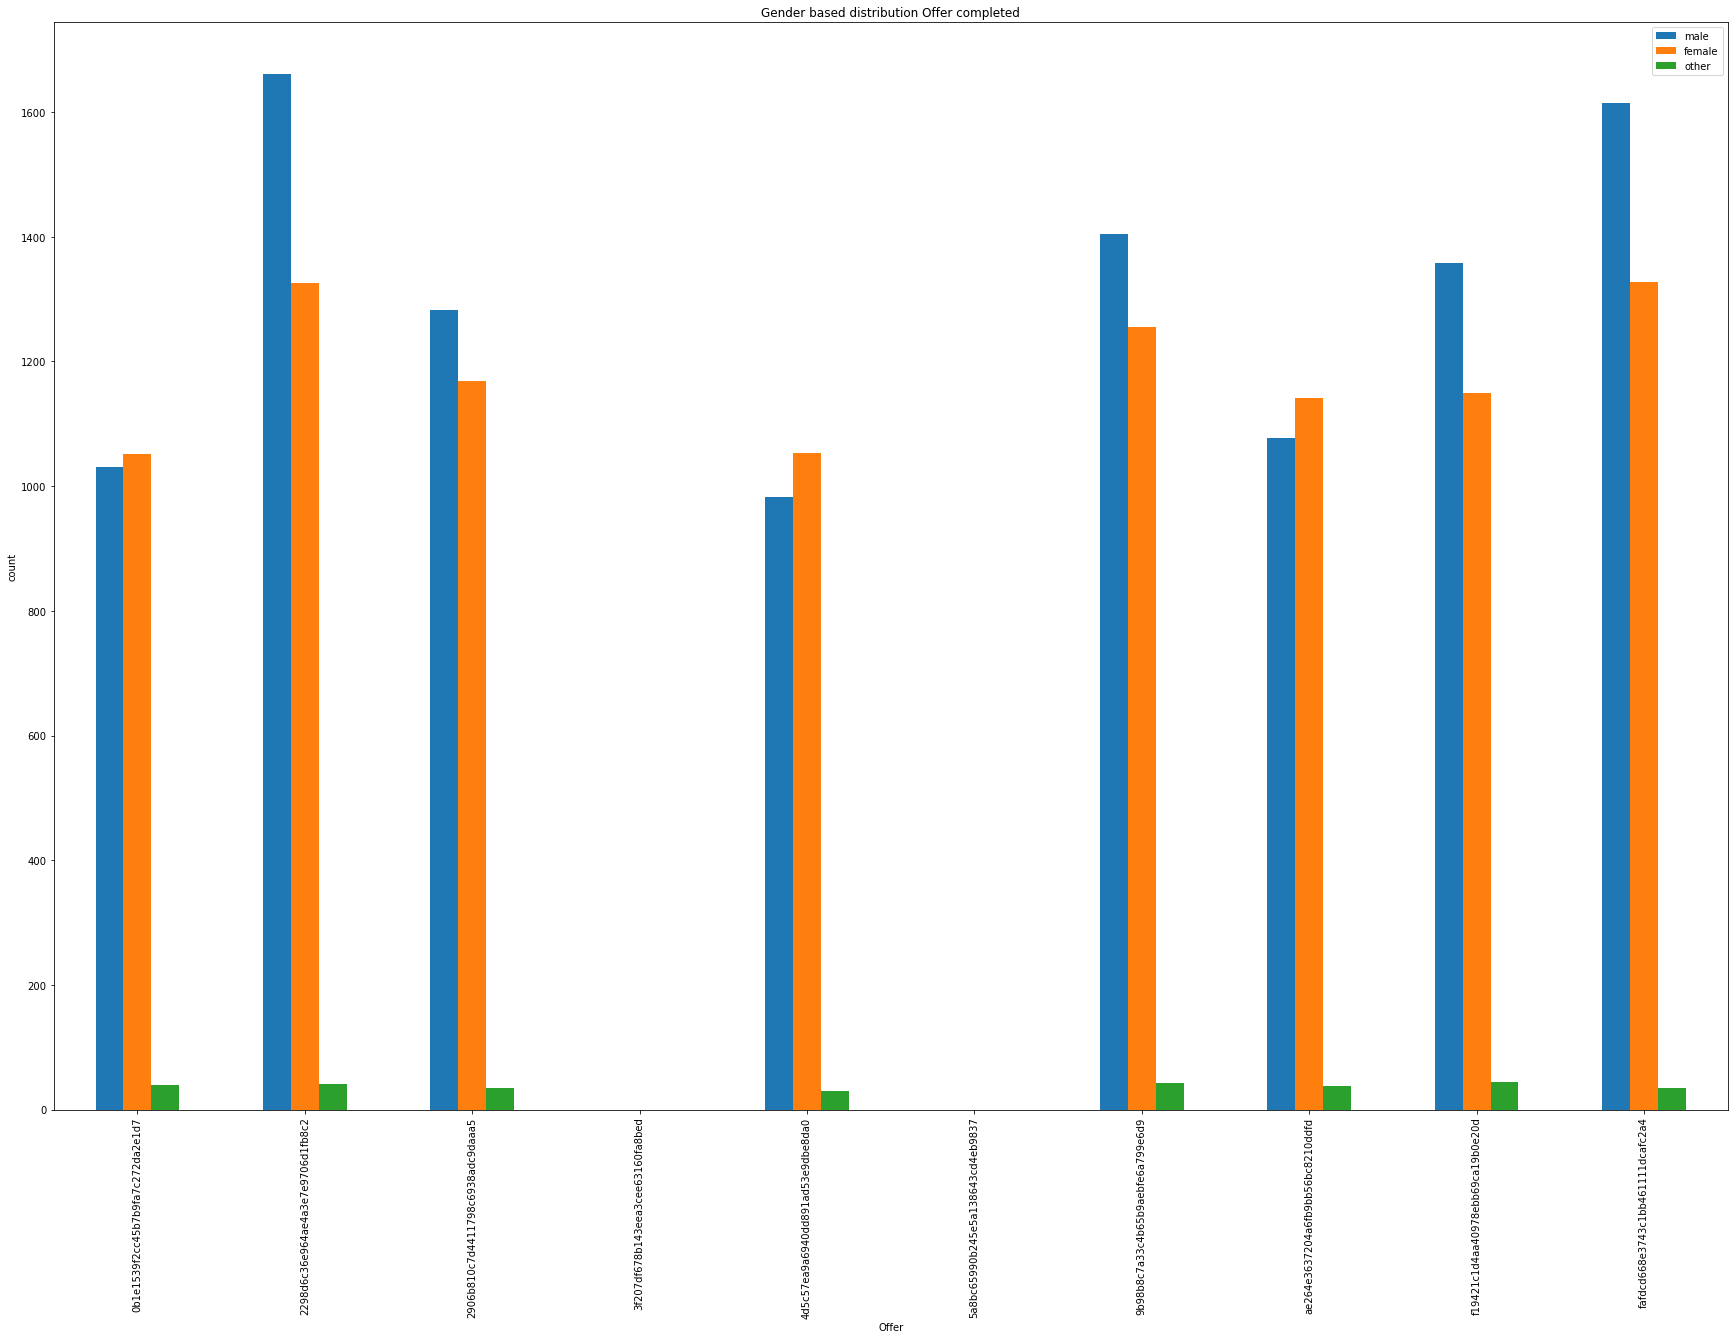

In [79]:
df_gender_event_groupby.plot(kind='bar', y=['male_event_offer_completed','female_event_offer_completed','other_event_offer_completed'], label=['male', 'female', 'other'])
plt.title('Gender based distribution Offer completed')
plt.rcParams["figure.figsize"] = (30,20)
plt.ylabel('count')
plt.xlabel('Offer');

In [80]:
df_gender_event_groupby

,male_event_offer_completed,male_event_offer_viewed,female_event_offer_completed,female_event_offer_viewed,other_event_offer_completed,other_event_offer_viewed
offer_id,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,1030.0,690.0,1052.0,588.0,39,31
2298d6c36e964ae4a3e7e9706d1fb8c2,1661.0,2145.0,1326.0,1481.0,41,50
2906b810c7d4411798c6938adc9daaa5,1283.0,1061.0,1168.0,902.0,35,39
3f207df678b143eea3cee63160fa8bed,0.0,1088.0,0.0,897.0,0,37
4d5c57ea9a6940dd891ad53e9dbe8da0,983.0,2137.0,1054.0,1489.0,30,43
5a8bc65990b245e5a138643cd4eb9837,0.0,2011.0,0.0,1371.0,0,56
9b98b8c7a33c4b65b9aebfe6a799e6d9,1404.0,1148.0,1255.0,907.0,43,42
ae264e3637204a6fb9bb56bc8210ddfd,1078.0,2003.0,1141.0,1336.0,37,48
f19421c1d4aa40978ebb69ca19b0e20d,1358.0,2068.0,1150.0,1452.0,44,52


Many conclusions can be drawn from this first part of analysis. We can also conduct te same type of heuristics to finally suggest what demographic groups are more sensitive to which offers. Initially here we can see that the infromational offers don't generate any completed offer transactions. In this project the focus will be more on developing the code for the predictive model to be able to target at wheteher an offer will be completed or not. We will look at what features from all the ones defined above are best for prediciting whether an offer will be completed or not. For this we will first normalize data, use SelectKBest features to just keep those features that have the highest scores and then define the model that will give us the best accuracy score. For this we will first split the data into train and test so we can then validate our model. The focus here is to define the predicitive model, all other steps at this stage will not be given that much importance. 

In [81]:
complete_starbucks_df_clean.isna().sum()

customer_id                        0
offer_id                           0
event_offer_received               0
event_offer_viewed                 0
event_offer_completed              0
total_amount_before_transaction    0
age                                0
income                             0
customer_loyalty_days              0
gender_F                           0
gender_M                           0
gender_O                           0
offer_reward                       0
difficulty                         0
duration                           0
email                              0
mobile                             0
social                             0
web                                0
offer_type_bogo                    0
offer_type_discount                0
offer_type_informational           0
dtype: int64

__Select features and build Predicitive Model for Offer completion__

In [82]:
complete_starbucks_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38114 entries, 0 to 38113
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   customer_id                      38114 non-null  object 
 1   offer_id                         38114 non-null  object 
 2   event_offer_received             38114 non-null  uint8  
 3   event_offer_viewed               38114 non-null  uint8  
 4   event_offer_completed            38114 non-null  uint8  
 5   total_amount_before_transaction  38114 non-null  float64
 6   age                              38114 non-null  int64  
 7   income                           38114 non-null  float64
 8   customer_loyalty_days            38114 non-null  int64  
 9   gender_F                         38114 non-null  uint8  
 10  gender_M                         38114 non-null  uint8  
 11  gender_O                         38114 non-null  uint8  
 12  offer_reward      

For the features we will select all except for the target Y which will be event_offer_completion and customer_id and offer_id

In [83]:
features = complete_starbucks_df_clean.drop(columns=['offer_id','customer_id','event_offer_completed'])
target = complete_starbucks_df_clean['event_offer_completed']

In [84]:
features

,event_offer_received,event_offer_viewed,total_amount_before_transaction,age,income,customer_loyalty_days,gender_F,gender_M,gender_O,offer_reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,1,0,58.40,33,72000.0,2217,0,1,0,2,10,7,1,1,0,1,0,1,0
1,1,0,60.67,19,65000.0,2472,1,0,0,2,10,7,1,1,0,1,0,1,0
2,1,0,9.71,56,47000.0,1985,0,1,0,2,10,7,1,1,0,1,0,1,0
3,1,1,307.30,58,119000.0,1987,1,0,0,2,10,7,1,1,0,1,0,1,0
4,1,0,5.95,24,42000.0,2075,0,1,0,2,10,7,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38109,1,1,12.84,37,70000.0,2250,0,1,0,10,10,7,1,1,1,0,1,0,0
38110,1,1,74.97,57,92000.0,1907,0,1,0,10,10,7,1,1,1,0,1,0,0
38111,1,1,42.61,40,32000.0,2281,0,1,0,10,10,7,1,1,1,0,1,0,0
38112,1,1,154.31,67,77000.0,2278,1,0,0,10,10,7,1,1,1,0,1,0,0


In [85]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38114 entries, 0 to 38113
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   event_offer_received             38114 non-null  uint8  
 1   event_offer_viewed               38114 non-null  uint8  
 2   total_amount_before_transaction  38114 non-null  float64
 3   age                              38114 non-null  int64  
 4   income                           38114 non-null  float64
 5   customer_loyalty_days            38114 non-null  int64  
 6   gender_F                         38114 non-null  uint8  
 7   gender_M                         38114 non-null  uint8  
 8   gender_O                         38114 non-null  uint8  
 9   offer_reward                     38114 non-null  int64  
 10  difficulty                       38114 non-null  int64  
 11  duration                         38114 non-null  int64  
 12  email             

In [132]:

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [133]:
scaler = StandardScaler()

In [134]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

We perform a comparision of several classifiers and perform hyperparamter tuning for them to oprtimize for the best f1 score. This is the metric we optimize, since the f1 score is a way to take into account both precision and recall and therefore the metric that compensantes and optimized the full picture.

Firt we will not tune the hyperparameters but use the default values in order to get the classifier with the best score and then we will perform hypterparameter tuning over this classifier to optimize computational efforts.

In [117]:
def classifier_fit (model, param_grid, X_train, y_train): 

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
    grid.fit(X_train, y_train)
    
    return grid.best_score_, grid.best_estimator_, grid.best_params_, grid

In [118]:
best_score_randomforest, best_estimator_randomforest, best_params_randomforest, grid_randomforest = classifier_fit (model=RandomForestClassifier(random_state = 42),param_grid = {}, X_train=X_train, y_train=y_train)
best_score_KNN, best_estimator_KNN, best_params_KNN, grid_KNN = classifier_fit (model=KNeighborsClassifier(),param_grid = {}, X_train=X_train, y_train=y_train)
best_score_GaussianNB, best_estimator_GaussianNB, best_params_GaussianNB, grid_GaussianNB = classifier_fit (model=GaussianNB(),param_grid = {}, X_train=X_train, y_train=y_train)
best_score_DecisionTreeClassifier, best_estimator_DecisionTreeClassifier, best_params_DecisionTreeClassifier, grid_DecisionTreeClassifier = classifier_fit (model=DecisionTreeClassifier(random_state = 42),param_grid = {}, X_train=X_train, y_train=y_train)
best_score_SVC, best_estimator_SVC, best_params_SVC, grid_SVC = classifier_fit (model=SVC(),param_grid = {}, X_train=X_train, y_train=y_train)
best_score_AdaBoostClassifier, best_estimator_AdaBoostClassifier, best_params_AdaBoostClassifier, grid_AdaBoostClassifier = classifier_fit (model=AdaBoostClassifier(random_state = 42),param_grid = {}, X_train=X_train, y_train=y_train)


In [91]:
best_score_randomforest

0.8409429067463577

In [92]:
best_score_KNN

0.8171352612651528

In [93]:
best_score_GaussianNB

0.7973372264785442

In [94]:
best_score_DecisionTreeClassifier

0.7827045165122728

In [95]:
best_score_SVC

0.843274992563997

In [96]:
best_score_AdaBoostClassifier

0.8393592721654098

Hyperparameter tuning for the best 2 models with highest f1 score which are SVC and RandomForestClassifier.

In [97]:
param_grid_random_forest= {'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 10],
 'n_estimators': [200, 2000]}

In [98]:
param_grid_SVC = {
    "kernel": ["linear","rbf"],
    "C":[0.1,1,10]
}

In [99]:
best_score_refined_SVC, best_estimator_refined_SVC, best_params_refined_SVC, grid_refined_SVC = classifier_fit (model=SVC(),param_grid = param_grid_SVC, X_train=X_train, y_train=y_train)

In [119]:
best_score_refined_randomforest, best_estimator_refined_randomforest, best_params_refined_randomforest, grid_randomforest = classifier_fit (model=RandomForestClassifier(random_state = 42),param_grid = param_grid_random_forest, X_train=X_train, y_train=y_train)


In [120]:
best_score_refined_SVC

0.8447512880163144

In [121]:
best_score_refined_randomforest

0.8484886204179931

In [122]:
best_estimator_refined_randomforest.feature_importances_

array([0.        , 0.0294829 , 0.19876059, 0.05840526, 0.09133702,
       0.13794981, 0.00848478, 0.0101331 , 0.00042535, 0.11647344,
       0.11264987, 0.09761996, 0.        , 0.00286236, 0.00654636,
       0.00834296, 0.01237585, 0.01613036, 0.09202003])

In [123]:
features.columns.tolist()

['event_offer_received',
 'event_offer_viewed',
 'total_amount_before_transaction',
 'age',
 'income',
 'customer_loyalty_days',
 'gender_F',
 'gender_M',
 'gender_O',
 'offer_reward',
 'difficulty',
 'duration',
 'email',
 'mobile',
 'social',
 'web',
 'offer_type_bogo',
 'offer_type_discount',
 'offer_type_informational']

Based on the scores we will select the best model to be the RandomForestClassifier with the above hyperparameters. Now we will go on into looking at what are the features of the model with most importance.

__Feature Importance__

In [106]:
feature_importance_df = pd.DataFrame(best_estimator_refined_randomforest.feature_importances_, columns=['feature_importance'],index=features.columns.tolist())

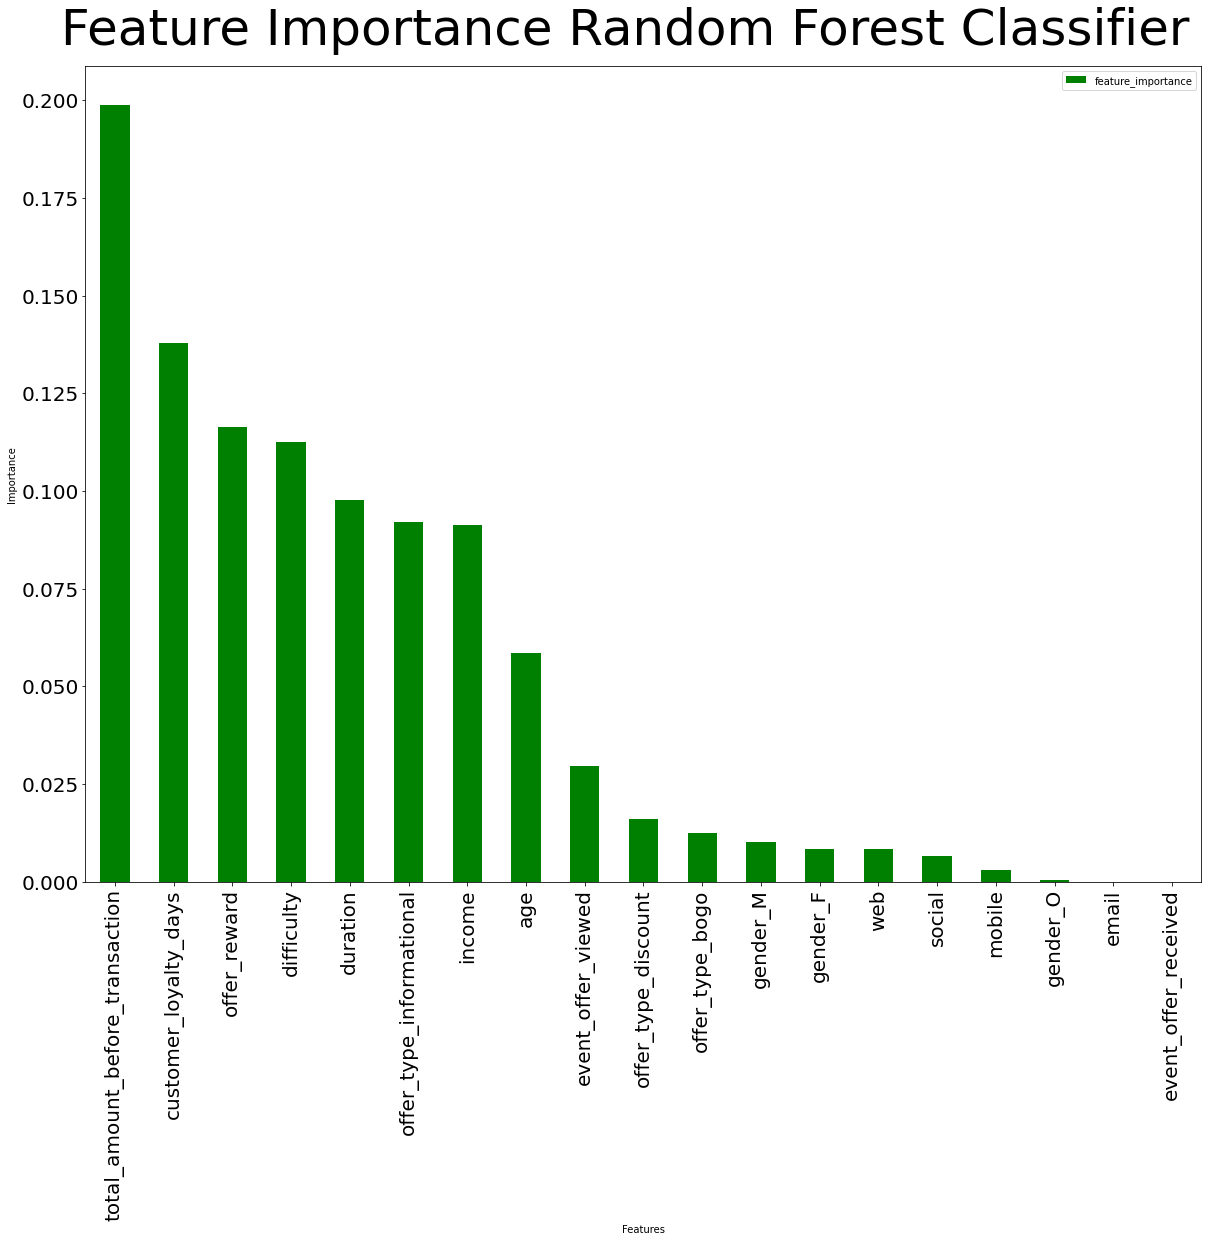

In [115]:
feature_importance_df.sort_values('feature_importance', ascending=False).plot(kind='bar', color='green')
plt.figtext(.5,.9,'Feature Importance Random Forest Classifier', fontsize=50, ha='center')
plt.rcParams["figure.figsize"] = (20,15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Importance')
plt.xlabel('Features');

We can see that the features that are the most important for the model are: 
1) The total amount spent by the customer prior to a trasaction the customer \
2) The customer loyalty days \
3) And the quantity of the reward for the offer 

The three features intuitevely make a lot of sense that are highly imporant for a model that predicts whether an offer will be completed by a customer or not. 

__Validate Test Data__

In [136]:
grid_randomforest.predict(X_test)

array([0, 0, 1, ..., 0, 0, 1], dtype=uint8)

In [139]:
# Predict with X_test features
y_pred = grid_randomforest.predict(X_test)

# Compare predictions to y_test labels
test_score_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy Score on test data set:', test_score_accuracy)

Accuracy Score on test data set: 0.8327940533449935


In [141]:

# Compare predictions to y_test labels
test_score_precision = precision_score(y_test, y_pred)
print('Precision Score on test data set:', test_score_precision)

Precision Score on test data set: 0.811408789885611


In [142]:

# Compare predictions to y_test labels
test_score_recall = recall_score(y_test, y_pred)
print('Recall Score on test data set:', test_score_recall)

Recall Score on test data set: 0.8910743801652893


In [144]:
# Compare predictions to y_test labels
f1_score_recall = f1_score(y_test, y_pred)
print('F1 Score on test data set:', f1_score_recall)

F1 Score on test data set: 0.8493776587364108


We see very good scores for accuracy, precision, recall and f1 score for the test dataset to be able to predict if an offer is completed based on all the features defined. We could potentially select Kbest features to reduce the number of features to the ones that perfor best for this model as a refinement step.

__Conclusions__

I combined the data from 3 different datasets, the profile dataset that hads customer data , the portfolio dataset which hads offer data and finally the transcript dataset which records the transactions that have been made at Starbucks.

Then after exploring and cleaning the datasets, new features have been defined with the data specially related to cusomter loyalty days which is the number of days since the customer became a member, and the amount of money spend before a transaction and if a offer has been received, viewed and completed for that transaction. These two features are the most important features for the predicitve model that is defined which is using the RandomForestClassifier. 

For the predictive model, after performing hyperparamter tuning, the F1 score obtaintedof the model is 0.5849, the precision is 0.811, the accuracy score is 0.833 and the recall is 0.891 which all make a quite good score of the model. However, when looking at the data I conclude that there is not too much data that the model is ingesting and it would be nice to get more data to define a even more robust model and with more demographic data for instance. This could help us define a recommendation system for new customers that have a similar demographic profile (age, salary, gender, region, etc) in order to send them the offers that is interesting for similar people for whom we do have data that have a similar profile. 

